# Thesis data generation and analysis

### Imports, variables and plotting setup

In [48]:
import os
import numpy as np
import string
import random

import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline


# import configuration variable with path
# to the Golang code of the experiment
from config import EXPERIMENT_PATH

# build Golang program
os.system("go build -o " + EXPERIMENT_PATH + "/thesis " + EXPERIMENT_PATH + "/*.go")


# plotting config
plt.style.use('seaborn-talk')
sns.set_style("white")
sns.set_context("paper", font_scale=1.5)

np.random.seed(2424)

### Utility functions

In [49]:
# run experiment with given params
def runExperiment(name, algo="mt", op="build"):
    os.system(EXPERIMENT_PATH + "/thesis " + "-algo=" + algo +  " -op=" + op + " -name=" + name)

In [50]:

def random_string(length):
    return ''.join(random.choice(string.ascii_letters) for m in range(length))

def gen_string(b_length):
    return random_string(b_length)

### Generate data

In [53]:
MIN_TRANS = 100
MAX_TRANS = 3000
INCREMENT = 50

# repeat incrementing number of blocks of 50
for i in range(MIN_TRANS, 150, INCREMENT):
    # generate i uniformly randomly distributed integers n
    # between 900 and 1100. the block length is n*8 bytes
    lengths = np.rint(np.random.uniform(900, 1100, i))
    
    # the function gen_string is vectorized, ready to 
    # process arrays 
    vfunc = np.vectorize(gen_string)
    
    # generates strings of given lengths
    samples = vfunc(lengths.astype(int))
    
    # write to specific file, one transaction per row 
    with open(EXPERIMENT_PATH + '/source/uniform_samples_' + str(i) + '.txt', 'w') as output:
        for sample in samples:
            output.write(sample + '\n')

In [54]:
runExperiment("uniform_samples_100.txt")

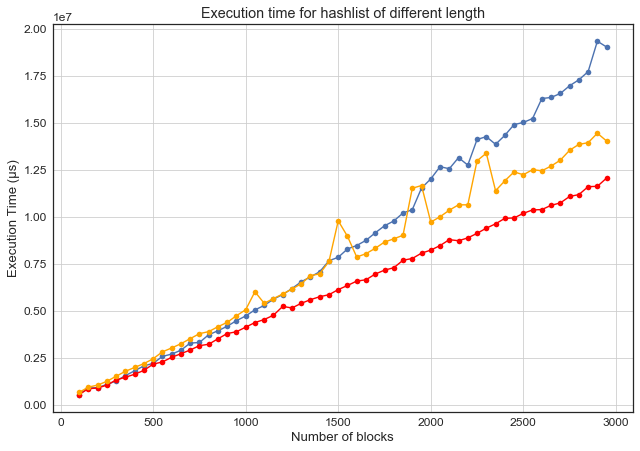

In [10]:
# read results from file
results = np.loadtxt('results/results.txt', delimiter=',')
results_mt = np.loadtxt('results/results_mt.txt', delimiter=',')
results_mt2 = np.loadtxt('results/results_mt2.txt', delimiter=',')

# define intervals for x-axis
# TODO: change 1000 to MAX_TRANS when running experiment on whole dataset
lenghts = np.arange(MIN_TRANS, MAX_TRANS, INCREMENT, dtype=float)


# build plot (https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot)
plt.plot(lenghts, results, marker='o')
plt.title('Execution time for hashlist of different length')
plt.grid(True)
plt.xlabel('Number of blocks')
plt.ylabel('Execution Time (µs)')

plt.plot(lenghts, results_mt, color='red', marker='o')
plt.plot(lenghts, results_mt2, color='orange', marker='o')